In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import sklearn as sk 
import os 
import cv2
import albumentations as A
from PIL import Image 
from tensorflow import keras 
from sklearn.model_selection import train_test_split

In [2]:
training_path = "/kaggle/input/sp-society-camera-model-identification/train/train/"
testing_path = "/kaggle/input/sp-society-camera-model-identification/test/test/"
_,training_classes,_=next(os.walk(training_path))
#print(training_classes)


In [3]:
batch_size = 4
epochs = 50
learning_rate = 1e-3

In [4]:
_,_,testing_files = next(os.walk(testing_path))
#testing_files

In [5]:
training_paths = [] 
labels = [] 
for i in training_classes:
    _,_,filenames = next(os.walk(training_path+i))
    for j in filenames:
        training_paths.append(training_path+i+'/'+j)
        labels.append(i)

In [6]:
assert len(training_paths)==len(labels)

In [7]:
seed = 33

In [8]:
training_data = pd.DataFrame(training_paths,columns=['Training Image Path'])
classes = pd.DataFrame(labels)
classes = pd.get_dummies(classes) # One Hot Encode the class variables

In [9]:
training_data

,Training Image Path
0,/kaggle/input/sp-society-camera-model-identifi...
1,/kaggle/input/sp-society-camera-model-identifi...
2,/kaggle/input/sp-society-camera-model-identifi...
3,/kaggle/input/sp-society-camera-model-identifi...
4,/kaggle/input/sp-society-camera-model-identifi...
...,...
2745,/kaggle/input/sp-society-camera-model-identifi...
2746,/kaggle/input/sp-society-camera-model-identifi...
2747,/kaggle/input/sp-society-camera-model-identifi...
2748,/kaggle/input/sp-society-camera-model-identifi...


In [10]:
classes.head()

,0_HTC-1-M7,0_LG-Nexus-5x,0_Motorola-Droid-Maxx,0_Motorola-Nexus-6,0_Motorola-X,0_Samsung-Galaxy-Note3,0_Samsung-Galaxy-S4,0_Sony-NEX-7,0_iPhone-4s,0_iPhone-6
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [11]:
classes_dict = {'0':'HTC-1-M7',
                '1':'LG-Nexus-5x',
                '2':'Motorola-Droid-Maxx',
                '3':'Motorola-Nexus-6',
                '4':'Motorola-X',
                '5':'Samsung-Galaxy-Note3',
                '6':'Samsung-Galaxy-S4',
                '7':'Sony-NEX-7',
                '8':'iPhone-4s',
                '9':'iPhone-6'}

In [12]:
testing_data = pd.DataFrame(testing_files,columns=['Testing Image Path'])
testing_data

,Testing Image Path
0,img_b551817_manip.tif
1,img_90bf577_unalt.tif
2,img_44c7044_unalt.tif
3,img_6481076_unalt.tif
4,img_6f87d1f_manip.tif
...,...
2635,img_f5c6b8e_unalt.tif
2636,img_a9da818_manip.tif
2637,img_53bbd9f_unalt.tif
2638,img_db8cb11_unalt.tif


In [13]:
def read_img(path):
    temp = cv2.imread(path)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    return np.array(temp)

In [14]:
length = 512
training_transforms = A.Compose([A.RandomCrop(height=length,width=length),
                                A.RandomGamma(gamma_limit=(80,120),p=0.5),
                                A.JpegCompression(quality_lower=70,quality_upper=90,p=0.5),
                                A.GridDistortion(interpolation=cv2.INTER_CUBIC),
                                A.HorizontalFlip(p=0.3),
                                A.VerticalFlip(p=0.5)])
    

                                
testing_augmentation = A.Compose([
                                  A.CenterCrop(height=length,width=length)])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:967: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


In [15]:
class Dataset(keras.utils.Sequence):
    def __init__(self,x,y,batch_size,augmentations,test):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augmentations = augmentations 
        self.test = test 
    def __len__(self):
        return int(len(self.x)/self.batch_size)
    def __getitem__(self,index):
        batched_x = self.x.iloc[index*self.batch_size:(index+1)*self.batch_size].to_numpy()
        if(self.test):
            images = [(self.augmentations(image=read_img(i))['image']) for i in batched_x]
            
        else:
            batched_y = self.y.iloc[index*self.batch_size : (index+1)*self.batch_size,:]
            images = [(self.augmentations(image=read_img(i[0]))['image']) for i in batched_x]
        return np.array(images)if self.test else (np.array(images),batched_y.values)

In [16]:
dummy_dataset = Dataset(training_data,classes,batch_size=batch_size,augmentations=training_transforms,test=False)

(4, 512, 512, 3)
(4, 10)


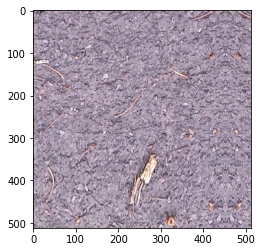

In [17]:
(a,b)=dummy_dataset.__getitem__(5)
#print(a[0])
print(a.shape)
#print(b)
print(b.shape)
plt.imshow(a[0])



In [18]:
def keras_model(length,input_size,output_classes):
    ipt_layer = keras.Input(shape=(length,length,3))
    conv1 = keras.layers.Conv2D(filters=512,kernel_size=7,activation='relu',strides=1)(ipt_layer)
    pool1 = keras.layers.MaxPool2D()(conv1)
    conv2 = keras.layers.Conv2D(filters=256,kernel_size=5,activation='relu',strides=1)(pool1)
    pool2 = keras.layers.MaxPool2D()(conv2)
    conv3 = keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu',strides=1)(pool2)
    pool3 = keras.layers.MaxPool2D()(conv3)
    conv4 = keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu',strides=1)(pool3)
    pool4 = keras.layers.MaxPool2D()(conv4)
    conv5 = keras.layers.Conv2D(filters=32,kernel_size=1,activation='relu',strides=1)(pool4)
    flatten = keras.layers.Flatten()(conv5)
    dense_1 = keras.layers.Dense(200,activation='tanh')(flatten)
    op_layer = keras.layers.Dense(output_classes,activation='softmax')(dense_1)
    optimiser = keras.optimizers.Adam(learning_rate =learning_rate)
    losses = keras.losses.CategoricalCrossentropy()
    metrics = keras.metrics.Accuracy()
    model = keras.Model(inputs = ipt_layer,outputs = op_layer)
    model.compile(optimizer=optimiser,loss=losses,metrics=metrics)
    return model

In [19]:
training_model = keras_model(length,length*length*3,10)

2021-12-03 08:26:17.446773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 08:26:17.533991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 08:26:17.534751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 08:26:17.535885: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
training_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 506, 506, 512)     75776     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 253, 253, 512)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 249, 249, 256)     3277056   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 128)     295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 128)       0     

In [21]:
xtrain,xval,ytrain,yval = train_test_split(training_data,classes,test_size=0.1,shuffle=True,random_state=seed)

In [22]:
print(len(xtrain),len(xval))
print(len(ytrain),len(yval))

2475 275
2475 275


In [23]:
training_dataset = Dataset(xtrain,ytrain,batch_size=batch_size,augmentations=training_transforms,test=False)
validation_dataset = Dataset(xval,yval,batch_size=batch_size,augmentations=training_transforms,test=False)

print(len(training_dataset))
print(len(validation_dataset))

618
68


In [24]:
model_file = "output/base_model_weights.hd5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]


In [25]:
training_model.fit(training_dataset,validation_data=validation_dataset,epochs=epochs,batch_size=batch_size,callbacks=callbacks_list,verbose=1)

2021-12-03 08:26:21.151563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-12-03 08:26:23.928970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


618/618 [==============================] - 740s 1s/step - loss: 2.4759 - accuracy: 0.0000e+00 - val_loss: 2.3799 - val_accuracy: 0.0000e+00


2021-12-03 08:38:42.125271: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
618/618 [==============================] - 751s 1s/step - loss: 2.3754 - accuracy: 0.0000e+00 - val_loss: 2.3993 - val_accuracy: 0.0000e+00
Epoch 3/50
618/618 [==============================] - 730s 1s/step - loss: 2.3937 - accuracy: 0.0000e+00 - val_loss: 2.3388 - val_accuracy: 0.0000e+00

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 4/50
618/618 [==============================] - 720s 1s/step - loss: 2.3677 - accuracy: 0.0000e+00 - val_loss: 2.3459 - val_accuracy: 0.0000e+00
Epoch 5/50
618/618 [==============================] - 715s 1s/step - loss: 2.3669 - accuracy: 0.0000e+00 - val_loss: 2.4109 - val_accuracy: 0.0000e+00

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
Epoch 6/50
618/618 [==============================] - 698s 1s/step - loss: 2.3685 - accuracy: 0.0000e+00 - val_loss: 2.3597 - val_accuracy: 0.0000e+00
Epoch 00006: early stopping


In [26]:
sample_submission = pd.read_csv('/kaggle/input/sp-society-camera-model-identification/sample_submission.csv')
sample_submission.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-6
1,img_001e31c_unalt.tif,iPhone-6
2,img_00275cf_manip.tif,iPhone-6
3,img_0034113_unalt.tif,iPhone-6
4,img_00344b7_unalt.tif,iPhone-6


In [27]:
x_test = testing_path+sample_submission['fname']
#x_test = x_test.to_numpy()
print(x_test[0])

#training_model.load_model(model_file)
x_test = Dataset(x_test,x_test,test=True,batch_size=1,augmentations=testing_augmentation)

/kaggle/input/sp-society-camera-model-identification/test/test/img_0002a04_manip.tif


In [28]:
training_model = tf.keras.models.load_model(model_file)
predicted = training_model.predict(x_test)

In [29]:
print(predicted)

[[0.06095015 0.10891831 0.0576061  ... 0.11436604 0.16059357 0.09988847]
 [0.06095015 0.10891831 0.0576061  ... 0.11436604 0.16059357 0.09988847]
 [0.05908068 0.09871521 0.06887452 ... 0.12860693 0.15605588 0.14055265]
 ...
 [0.06095015 0.10891831 0.0576061  ... 0.11436604 0.16059357 0.09988847]
 [0.06095015 0.10891831 0.0576061  ... 0.11436604 0.16059357 0.09988847]
 [0.06095015 0.10891831 0.0576061  ... 0.11436604 0.16059357 0.09988847]]


In [30]:
test_labels = []
for item in predicted.argmax(axis=1):
    test_labels.append(classes_dict[str(item)])

In [31]:
sample_submission['camera'] = test_labels
sample_submission.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-4s
1,img_001e31c_unalt.tif,iPhone-4s
2,img_00275cf_manip.tif,iPhone-4s
3,img_0034113_unalt.tif,iPhone-4s
4,img_00344b7_unalt.tif,iPhone-4s


In [32]:
sample_submission.to_csv("submission.csv", index=False)